# MultiSensor Dataset Preparation 
- Experiment data: March 2024. Aluminum, Laser-Wire DED
- Aurthor: Chen Lequn

### Notebook 2b: Feature analysis

- Using the handcrafted features audio stream
- Audio features: spectral centroid, spectral bandwidth, flux, etc.
- Feature visualization, correlation analysis
- Dimensionality reduction


In [1]:
from sklearnex import patch_sklearn, config_context
# import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
# import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV  
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [4]:
import sys
sys.path.insert(0, '../utils')
import glob
import os

In [5]:
def plot_data_distribution(data, variable, title, filename, figure_size=(7, 6)):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Create the countplot
    sns.countplot(x=variable, data=data, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5, ax=ax, alpha = 0.9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Add percentages above each bar
    total = len(data)
    max_height = 0
    for p in ax.patches:
        max_height = max(max_height, p.get_height())
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
    
    # Extend the y-axis for better visibility of annotations
    ax.set_ylim([0, max_height * 1.2])
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel("Categories", fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Add grid
    ax.grid(True, which='both', axis='y', linestyle='dotted', linewidth=0.5, alpha=0.7, color='black')
    
    # Show all four edges of the plot
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Show the plot
    plt.tight_layout()
    save_fig(f"{filename}")
    plt.show()

In [6]:
PROJECT_ROOT_DIR = "../"


Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"
Annotation_file_path = os.path.join(Multimodal_dataset_PATH, "Annotation")

segmented_video_folder = os.path.join(Multimodal_dataset_PATH, 'segmented_videos')
segmented_audio_path = os.path.join(Multimodal_dataset_PATH, 'segmented_audio')
Video_path = os.path.join(Multimodal_dataset_PATH, 'Raw_Video', "Aluminium", 'avi')
Audio_path = os.path.join(Multimodal_dataset_PATH, 'Audio')
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'feature_analysis')

Dataset_path = os.path.join(Multimodal_dataset_PATH, 'Dataset')
final_audio_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_dataset = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")

os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

## Import Extracted features

In [7]:
# Read the data back from the HDF5 file into a new DataFrame
df_audio_dataset = pd.read_hdf(os.path.join(Dataset_path, 'df_audio_dataset_with_annotations(raw_audio).h5'), key='df')
df_audio_dataset = df_audio_dataset.drop(columns=['dynamic_complexity', 'loudness'])

df_audio_dataset

,audio_name,image_name,experiment_number,label_1,label_2,label_3,rms_energy,amplitude_envelope_mean,amplitude_envelope_std,zero_crossing_rate,...,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std
0,Exp_17_1_10.wav,Exp_17_1_10.jpg,17_1,LOF,NaN,NaN,0.031746,0.038982,0.014304,0.064399,...,-1.955670,7.565694,6.784209,13.263989,-4.241771,7.623967,10.760045,6.365362,-4.255302,6.843529
1,Exp_17_1_11.wav,Exp_17_1_11.jpg,17_1,LOF,NaN,NaN,0.046936,0.053492,0.018727,0.033787,...,7.764361,6.547935,10.695354,7.944485,0.243526,8.428101,10.609675,6.292929,-4.174980,7.595537
2,Exp_17_1_12.wav,Exp_17_1_12.jpg,17_1,LOF,NaN,NaN,0.024222,0.033361,0.013914,0.043991,...,0.100900,4.152504,1.597273,6.513865,-0.382829,5.145632,7.629467,9.252165,-2.734367,4.957322
3,Exp_17_1_2.wav,Exp_17_1_2.jpg,17_1,LOF,NaN,NaN,0.034430,0.041273,0.012582,0.071202,...,-7.307548,8.177770,14.585797,9.160913,-8.542147,8.239860,11.234342,7.819167,-10.741705,5.996997
4,Exp_17_1_3.wav,Exp_17_1_3.jpg,17_1,LOF,NaN,NaN,0.028317,0.034911,0.008767,0.108163,...,-7.398950,10.955479,11.769259,11.742193,-7.276566,8.582523,11.893761,7.696877,-10.677185,7.131041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,Exp_April_16_test_4_4.wav,Exp_April_16_test_4_4.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012902,0.015071,0.005879,0.099093,...,2.168951,6.490287,1.928032,8.401035,-1.724736,10.288368,-0.060851,8.381465,-12.953316,5.754806
6176,Exp_April_16_test_4_1.wav,Exp_April_16_test_4_1.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013222,0.015257,0.005407,0.084127,...,0.476796,9.227147,0.945553,7.366714,-1.322515,7.652929,-0.733449,5.396196,-14.786466,7.339162
6177,Exp_April_16_test_4_2.wav,Exp_April_16_test_4_2.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012246,0.014805,0.005100,0.093878,...,-0.026498,7.503857,2.117017,7.400688,-2.097013,8.523264,0.141502,6.387466,-10.734591,8.097878
6178,Exp_April_16_test_4_3.wav,Exp_April_16_test_4_3.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013367,0.016546,0.005384,0.087302,...,1.089101,6.276635,0.685349,5.679959,-5.039695,5.392179,-2.741401,4.763264,-13.847133,7.911690


In [8]:
df_audio_dataset['label_1'].unique()

['LOF', 'Balling', 'Laser-off', 'Non-defective', 'Degradation']
Categories (5, object): ['Balling', 'Degradation', 'LOF', 'Laser-off', 'Non-defective']

In [9]:
df_audio_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6180 entries, 0 to 6179
Data columns (total 87 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   audio_name                       6180 non-null   category
 1   image_name                       6180 non-null   category
 2   experiment_number                6180 non-null   object  
 3   label_1                          6180 non-null   category
 4   label_2                          3471 non-null   category
 5   label_3                          5 non-null      category
 6   rms_energy                       6180 non-null   float64 
 7   amplitude_envelope_mean          6180 non-null   float32 
 8   amplitude_envelope_std           6180 non-null   float32 
 9   zero_crossing_rate               6180 non-null   float64 
 10  loudness_vickers                 6180 non-null   float64 
 11  spectral_centroid_mean           6180 non-null   float64 
 12  spectr

Saving figure dataset_distribution.png


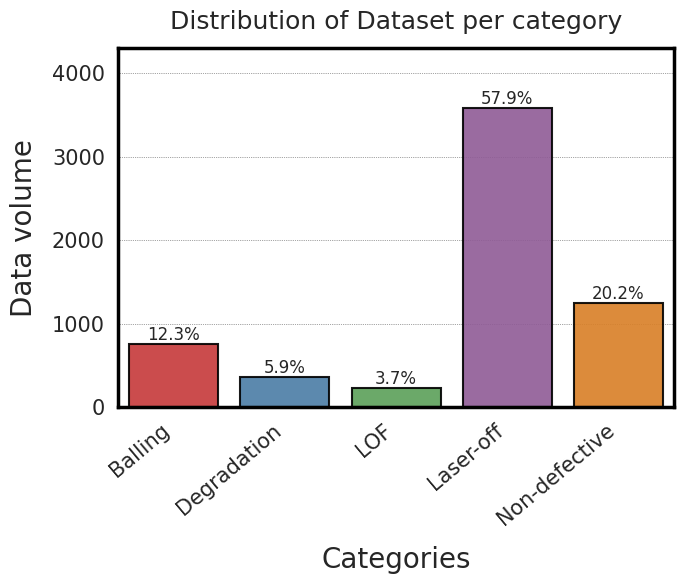

In [10]:
plot_data_distribution(df_audio_dataset, 'label_1', 
                       'Distribution of Dataset per category', 'dataset_distribution')

In [11]:
df_audio_dataset.groupby('label_1').describe()

rms_energy                                                    \
                   count      mean       std       min       25%       50%   
label_1                                                                      
Balling            759.0  0.036615  0.011186  0.015542  0.029474  0.034918   
Degradation        362.0  0.027720  0.004633  0.020054  0.024728  0.026529   
LOF                227.0  0.037376  0.007734  0.017045  0.032698  0.037531   
Laser-off         3581.0  0.014978  0.004659  0.006811  0.011907  0.013367   
Non-defective     1251.0  0.034116  0.013263  0.010868  0.026974  0.030895   

                                  amplitude_envelope_mean            ...  \
                    75%       max                   count      mean  ...   
label_1                                                              ...   
Balling        0.040887  0.088932                   759.0  0.041649  ...   
Degradation    0.029205  0.046762                   362.0  0.031775  ...   
LOF            0.041873  0.059481                   227.0  0.042988  ...   
Laser-off      0.017112  0.060663                  3581.0  0.017131  ...   
Non-defective  0.035634  0.101830                  1251.0  0.038728  ...   

              mfcc_12_mean           mfcc_12_std                      \
                       75%       max       count      mean       std   
label_1                                                                
Balling          -8.179971 -1.944077       759.0  7.107607  1.185337   
Degradation      -8.822986 -4.795195       362.0  7.178560  1.234938   
LOF              -8.015254 -2.734367       227.0  7.021842  1.212969   
Laser-off       -10.593283  1.810560      3581.0  7.104533  1.193354   
Non-defective    -7.591044 -1.181100      1251.0  7.023941  1.156196   

                                                                  
                    min       25%       50%       75%        max  
label_1                                                           
Balling        3.776521  6.318305  7.047492  7.885034  11.421926  
Degradation    4.328352  6.309853  7.184719  7.954706  11.499464  
LOF            3.341834  6.229365  7.046139  7.918830  10.824914  
Laser-off      3.464460  6.274926  7.059011  7.896545  11.935259  
Non-defective  3.708664  6.235863  7.013412  7.776168  10.738617  

[5 rows x 648 columns]

# Data feature analysis

## 1. Intra-modality Feature Correlation Analysis: Find the top N correlated features with a given feature 

__Redundant Features__: If multiple features are highly correlated, they often carry the same information. Reducing these can help in preventing multicollinearity in linear models and can also reduce the dimensionality of data, making models train faster and potentially improving generalization.

It can improve the model's generalization and reduce overfitting. It also makes the model simpler and faster to train.

In [12]:
audio_features = [
        'rms_energy', 'amplitude_envelope_mean','amplitude_envelope_std', 'zero_crossing_rate',
        'loudness_vickers', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_complexity_mean',
        'spectral_complexity_std', 'spectral_contrast_0_mean', 'spectral_contrast_0_std', 'spectral_contrast_1_mean',
        'spectral_contrast_1_std', 'spectral_contrast_2_mean', 'spectral_contrast_2_std', 'spectral_contrast_3_mean',
        'spectral_contrast_3_std', 'spectral_contrast_4_mean', 'spectral_contrast_4_std', 'spectral_contrast_5_mean',
        'spectral_contrast_5_std', 'spectral_valley_0_mean', 'spectral_valley_0_std', 'spectral_valley_1_mean',
        'spectral_valley_1_std', 'spectral_valley_2_mean', 'spectral_valley_2_std', 'spectral_valley_3_mean',
        'spectral_valley_3_std', 'spectral_valley_4_mean','spectral_valley_4_std', 'spectral_valley_5_mean',
        'spectral_valley_5_std', 'spectral_decrease_mean', 'spectral_decrease_std', 'spectral_energy_mean', 'spectral_energy_std',
        'spectral_energy_band_ratio_mean', 'spectral_energy_band_ratio_std',
        'spectral_flatness_mean', 'spectral_flatness_std', 'spectral_flux_mean', 'spectral_flux_std', 'spectral_rolloff_mean', 'spectral_rolloff_std',
        'spectral_strong_peak_mean', 'spectral_strong_peak_std', 'spectral_variance_mean', 'spectral_variance_std',
        'spectral_skewness_mean', 'spectral_skewness_std','spectral_kurtosis_mean', 'spectral_kurtosis_std',
        'spectral_crest_factor_mean', 'spectral_crest_factor_std','mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean',
        'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std',
        'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean',
        'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std',
        'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std','mfcc_12_mean', 'mfcc_12_std'
    ]


In [13]:
def plot_top_correlated_intermodality_features(dataset, feature_name, method='spearman', top_n=10):
    """
    Function to plot the top N correlated features with a given feature from the dataset.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - feature_name (str): The feature with which correlations are to be found.
    - method (str): The correlation method, default is 'spearman'.
    - top_n (int): Number of top correlated features to be plotted, default is 10.
    """
    
    
    # Ensure the provided feature_name exists in the dataset
    if feature_name not in dataset.columns:
        print(f"Feature '{feature_name}' not found in the dataset!")
        return

    # Determine if the given feature is from audio or vision
    if feature_name in audio_features:
        relevant_features = audio_features
    elif feature_name in vision_features:
        relevant_features = vision_features
    else:
        print(f"Feature '{feature_name}' is not recognized as audio or vision feature!")
        return

    # Compute correlations with the given feature using the specified correlation method
    correlations_with_feature = dataset[relevant_features].corr(method=method)[feature_name]
    
    # Get top N absolute correlations (including the feature_name)
    top_correlations = correlations_with_feature.abs().nlargest(top_n).index
    top_correlation_values = dataset[top_correlations].corr(method=method)

    # Print the top N features
    print(f"Top {top_n} features correlated with {feature_name} (using {method} correlation):")
    print (top_correlations)


    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 10)) #14, 12 or 10, 8
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {feature_name}", fontsize=18, y=1.02)
    # save_fig(f"intra-modality correlation_with_{feature_name}_{method}.png")

Top 10 features correlated with spectral_contrast_5_std (using spearman correlation):
Index(['spectral_contrast_5_std', 'spectral_valley_5_std',
       'spectral_valley_5_mean', 'spectral_flatness_std', 'mfcc_0_mean',
       'spectral_decrease_std', 'spectral_decrease_mean', 'rms_energy',
       'amplitude_envelope_mean', 'spectral_energy_mean'],
      dtype='object')
Saving figure intra_modality_correlation/correlation_with_spectral_contrast_5_std


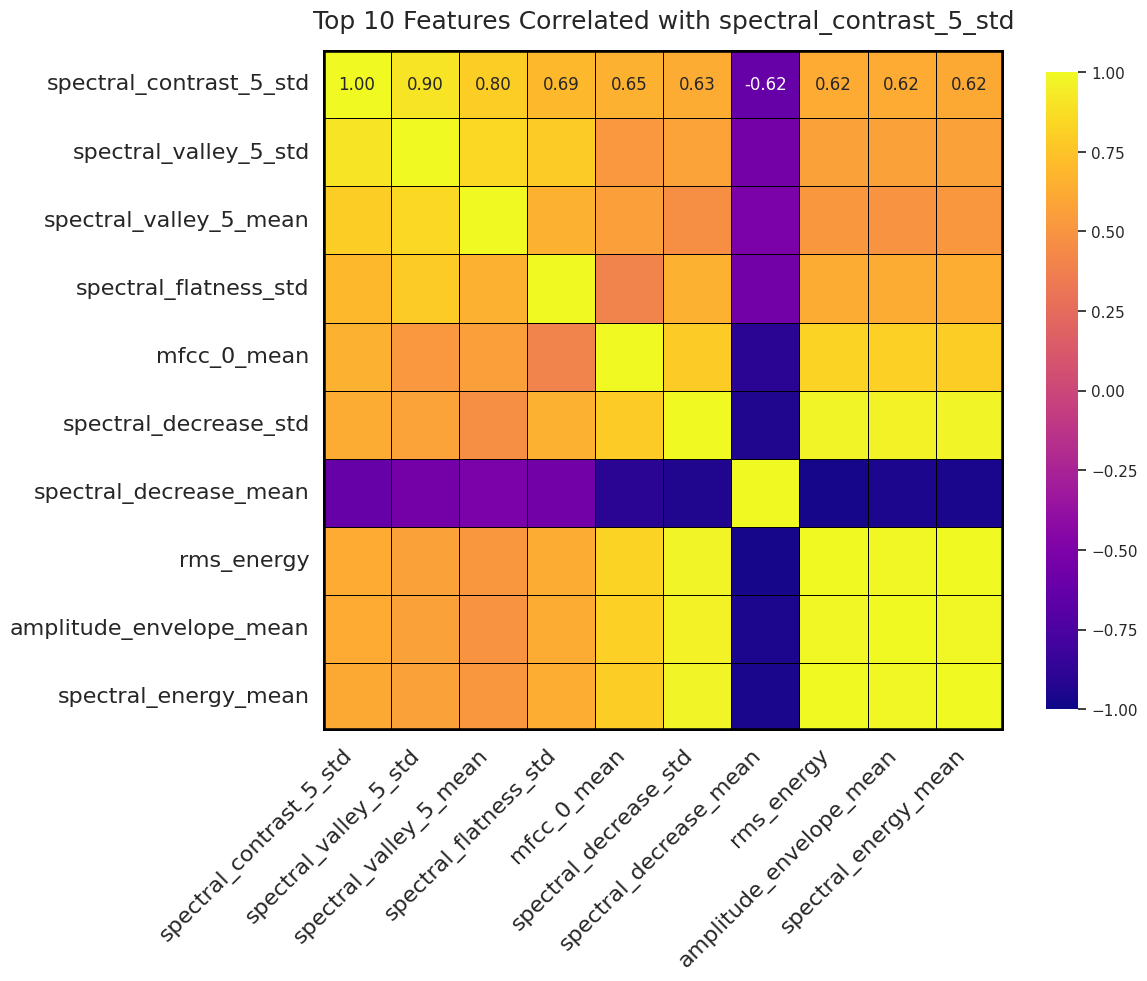

In [14]:
# Example usage:
feature_name = 'spectral_contrast_5_std'
plot_top_correlated_intermodality_features(df_audio_dataset, feature_name, method='spearman', top_n=10)
save_fig(os.path.join('intra_modality_correlation', f"correlation_with_{feature_name}"))

In [15]:
def find_highly_correlated_groups(dataset, audio_features, method='spearman', threshold=0.90):
    """
    Identifies groups of highly correlated features within a single modality (audio).
    """
    correlated_groups = []
    processed_features = set()  # Keep track of features that have been processed
    
    # Compute the correlation matrix for audio features
    audio_corr_matrix = dataset[audio_features].corr(method=method).abs()
    
    for feature in audio_features:
        if feature in processed_features:
            continue  # Skip features that have already been processed

        # Identify features highly correlated with the current feature
        correlations_with_feature = audio_corr_matrix[feature]
        high_correlation_features = correlations_with_feature[correlations_with_feature > threshold].index.tolist()
        
        # If there's a group of highly correlated features, add it to the result
        if len(high_correlation_features) > 1:
            correlated_groups.append(high_correlation_features)
            processed_features.update(high_correlation_features)  # Mark these features as processed

    return correlated_groups

In [16]:
from collections import defaultdict

def merge_overlapping_groups(groups):
    """
    Merge overlapping groups of features into unified groups.
    
    Args:
    - groups (list of list): List of feature groups to be merged.
    
    Returns:
    - List of merged feature groups.
    """
    # Initialize the mapping from feature to groups it belongs to
    feature_to_groups = defaultdict(set)
    
    # Populate the feature_to_groups mapping
    for i, group in enumerate(groups):
        for feature in group:
            feature_to_groups[feature].add(i)
    
    # Initialize the list of merged groups
    merged_groups = []
    
    # Initialize the set of processed group indices
    processed_groups = set()
    
    # Loop over each group and merge it with any overlapping groups
    for i, group in enumerate(groups):
        if i in processed_groups:
            continue
        
        # Initialize the merged group as the current group
        merged_group = set(group)
        
        # Initialize the set of groups to be processed
        groups_to_process = {i}
        
        # Merge all overlapping groups
        while groups_to_process:
            current_group_index = groups_to_process.pop()
            current_group = groups[current_group_index]
            
            # Mark the current group as processed
            processed_groups.add(current_group_index)
            
            # Update the merged group
            merged_group.update(current_group)
            
            # Add any unprocessed overlapping groups to groups_to_process
            for feature in current_group:
                overlapping_groups = feature_to_groups[feature] - processed_groups
                groups_to_process.update(overlapping_groups)
        
        # Add the merged group to the list of merged groups
        merged_groups.append(list(merged_group))
    
    return merged_groups

In [17]:
# Find groups of highly correlated features using the optimized function
correlated_feature_groups = find_highly_correlated_groups(df_audio_dataset, audio_features, threshold=0.97)

# Merge the overlapping correlated feature groups
merged_correlated_feature_groups = merge_overlapping_groups(correlated_feature_groups)

# Print the merged correlated feature groups
merged_correlated_feature_groups

[['rms_energy',
  'spectral_flux_mean',
  'spectral_decrease_std',
  'spectral_decrease_mean',
  'spectral_energy_std',
  'spectral_energy_mean',
  'amplitude_envelope_mean'],
 ['spectral_kurtosis_mean', 'spectral_skewness_mean']]


 Correlated group: ['rms_energy', 'spectral_flux_mean', 'spectral_decrease_std', 'spectral_decrease_mean', 'spectral_energy_std', 'spectral_energy_mean', 'amplitude_envelope_mean'] 

Top 10 features correlated with rms_energy (using spearman correlation):
Index(['rms_energy', 'spectral_energy_mean', 'amplitude_envelope_mean',
       'spectral_flux_mean', 'spectral_decrease_mean', 'spectral_energy_std',
       'spectral_decrease_std', 'amplitude_envelope_std', 'spectral_flux_std',
       'mfcc_0_mean'],
      dtype='object')
Saving figure intra_modality_correlation/correlation_with_rms_energy

 Correlated group: ['spectral_kurtosis_mean', 'spectral_skewness_mean'] 

Top 10 features correlated with spectral_kurtosis_mean (using spearman correlation):
Index(['spectral_kurtosis_mean', 'spectral_skewness_mean',
       'spectral_energy_band_ratio_mean', 'spectral_rolloff_mean',
       'zero_crossing_rate', 'spectral_rolloff_std', 'mfcc_1_mean',
       'spectral_crest_factor_mean', 'spectral

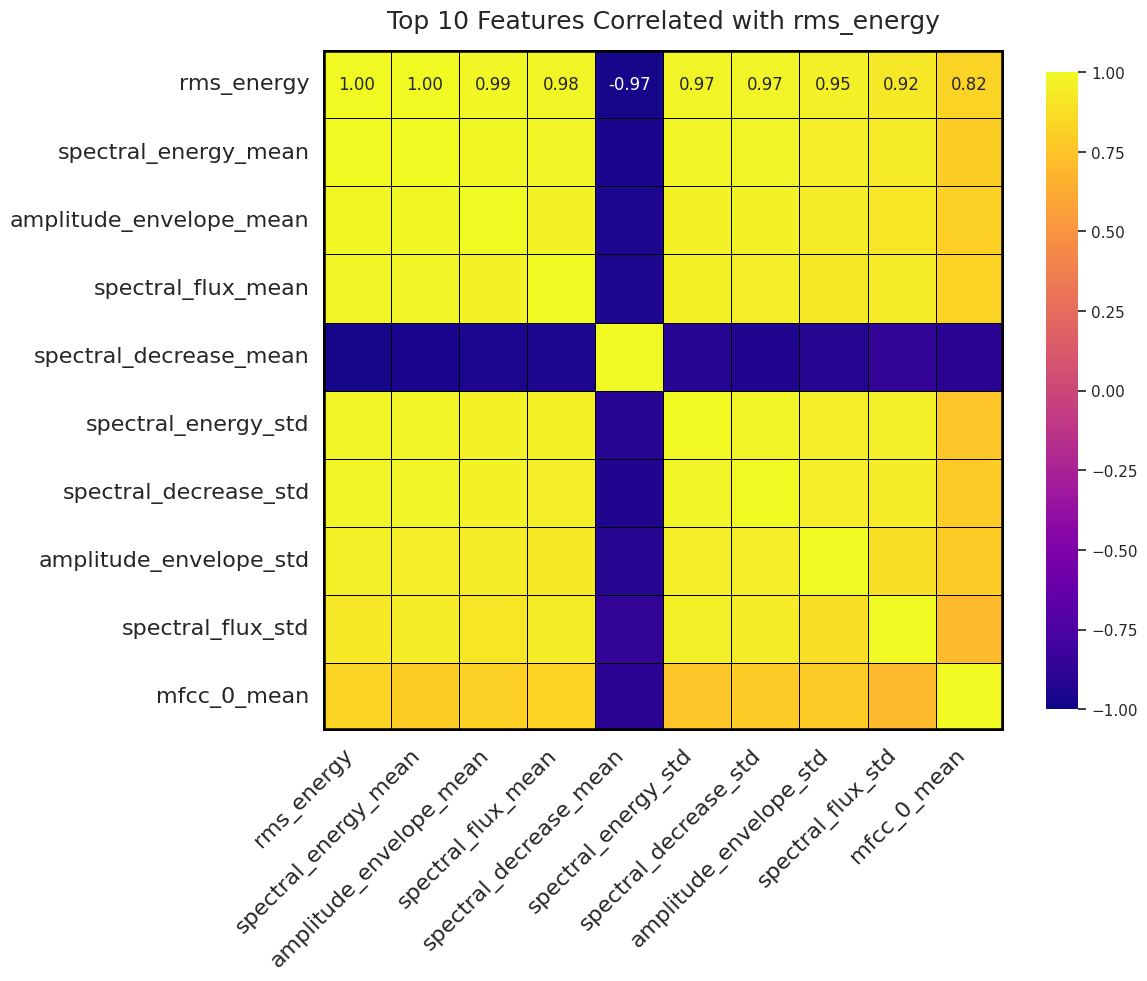

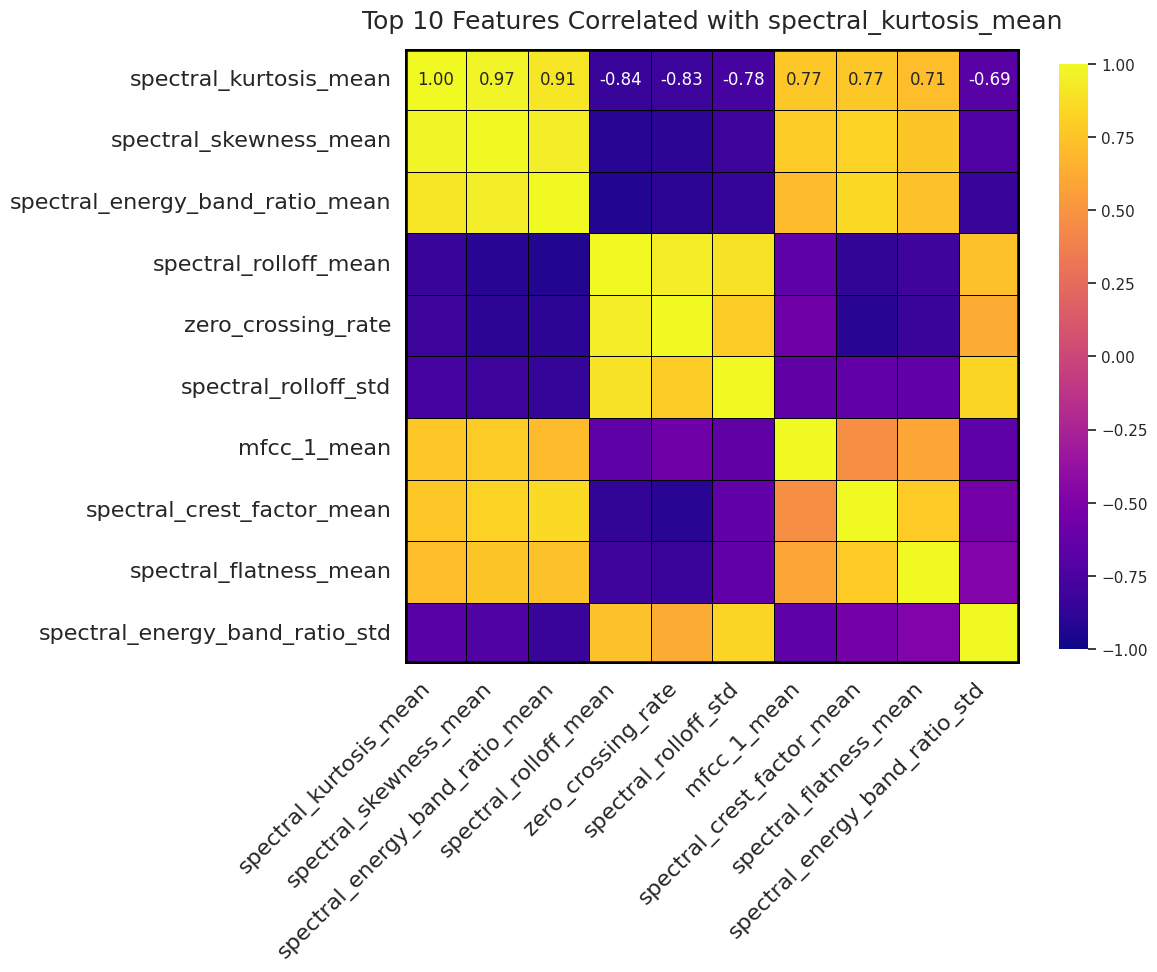

In [18]:
# Print and plot the first representative feature from each group
for group in merged_correlated_feature_groups:
    print(f"\n Correlated group: {group} \n")
    plot_top_correlated_intermodality_features(df_audio_dataset, group[0], method='spearman', top_n=10)
    save_fig(os.path.join('intra_modality_correlation', f"correlation_with_{group[0]}"))

### Conclusion: 

empty feature: `dynamic_complexity,loudness`

__correlation 0.97 result__:
1. ['spectral_energy_mean',
  'amplitude_envelope_mean',
  'spectral_decrease_std',
  'rms_energy',
  'spectral_flux_mean',
  'spectral_energy_std'],
2. ['spectral_kurtosis_mean', 'spectral_skewness_mean']]

__correlation 0.9 result__:
1. ['spectral_energy_mean','spectral_flux_std','amplitude_envelope_mean','spectral_decrease_std','rms_energy','spectral_energy_std','spectral_flux_mean','spectral_decrease_mean', 'amplitude_envelope_std'],
2. ['spectral_kurtosis_mean','spectral_rolloff_mean','spectral_skewness_mean','spectral_energy_band_ratio_mean','zero_crossing_rate'],
3. ['spectral_complexity_mean','spectral_valley_4_mean', 'spectral_valley_3_mean','spectral_valley_0_mean','loudness_vickers','spectral_valley_1_mean','mfcc_0_mean'],
4. ['spectral_contrast_5_std', 'spectral_valley_5_std']]

In [19]:
### --------------for 0.97 set-------------
redundant_features_097 = ['spectral_energy_mean', 'amplitude_envelope_mean', 'spectral_decrease_std', 'rms_energy', 'spectral_flux_mean', 
                          'spectral_energy_std', 'spectral_kurtosis_mean', 'spectral_skewness_mean']

# Remove these redundant columns from the df_multimodal DataFrame
df_dropped_097 = df_audio_dataset.drop(columns= redundant_features_097)

# Show some information about the updated DataFrame to confirm that the columns have been dropped
df_dropped_097.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6180 entries, 0 to 6179
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   audio_name                       6180 non-null   category
 1   image_name                       6180 non-null   category
 2   experiment_number                6180 non-null   object  
 3   label_1                          6180 non-null   category
 4   label_2                          3471 non-null   category
 5   label_3                          5 non-null      category
 6   amplitude_envelope_std           6180 non-null   float32 
 7   zero_crossing_rate               6180 non-null   float64 
 8   loudness_vickers                 6180 non-null   float64 
 9   spectral_centroid_mean           6180 non-null   float64 
 10  spectral_centroid_std            6180 non-null   float64 
 11  spectral_complexity_mean         6180 non-null   float64 
 12  spectr

In [20]:
### --------------for 0.90 set-------------
# Choose a representative feature from each group to keep, and list the rest as redundant
redundant_features_090 = ['spectral_energy_mean','spectral_flux_std','amplitude_envelope_mean','spectral_decrease_std','rms_energy','spectral_energy_std',
                          'spectral_flux_mean','spectral_decrease_mean', 'amplitude_envelope_std', 'spectral_kurtosis_mean','spectral_rolloff_mean',
                          'spectral_skewness_mean','spectral_energy_band_ratio_mean','zero_crossing_rate', 'spectral_complexity_mean','spectral_valley_4_mean', 
                          'spectral_valley_3_mean','spectral_valley_0_mean','loudness_vickers','spectral_valley_1_mean','mfcc_0_mean',
                          'spectral_contrast_5_std', 'spectral_valley_5_std']


# Remove these redundant columns from the DataFrame
df_dropped_090 = df_audio_dataset.drop(columns= redundant_features_090)

# Show some information about the updated DataFrame to confirm that the columns have been dropped
df_dropped_090.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6180 entries, 0 to 6179
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   audio_name                      6180 non-null   category
 1   image_name                      6180 non-null   category
 2   experiment_number               6180 non-null   object  
 3   label_1                         6180 non-null   category
 4   label_2                         3471 non-null   category
 5   label_3                         5 non-null      category
 6   spectral_centroid_mean          6180 non-null   float64 
 7   spectral_centroid_std           6180 non-null   float64 
 8   spectral_complexity_std         6180 non-null   float64 
 9   spectral_contrast_0_mean        6180 non-null   float32 
 10  spectral_contrast_0_std         6180 non-null   float32 
 11  spectral_contrast_1_mean        6180 non-null   float32 
 12  spectral_contrast_1_

In [21]:
df_dropped_090

,audio_name,image_name,experiment_number,label_1,label_2,label_3,spectral_centroid_mean,spectral_centroid_std,spectral_complexity_std,spectral_contrast_0_mean,...,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std
0,Exp_17_1_10.wav,Exp_17_1_10.jpg,17_1,LOF,NaN,NaN,4362.047929,1832.875195,0.832178,-0.798009,...,-1.955670,7.565694,6.784209,13.263989,-4.241771,7.623967,10.760045,6.365362,-4.255302,6.843529
1,Exp_17_1_11.wav,Exp_17_1_11.jpg,17_1,LOF,NaN,NaN,5763.114068,1866.408041,0.984647,-0.800737,...,7.764361,6.547935,10.695354,7.944485,0.243526,8.428101,10.609675,6.292929,-4.174980,7.595537
2,Exp_17_1_12.wav,Exp_17_1_12.jpg,17_1,LOF,NaN,NaN,2670.763492,2522.680778,1.181576,-0.876837,...,0.100900,4.152504,1.597273,6.513865,-0.382829,5.145632,7.629467,9.252165,-2.734367,4.957322
3,Exp_17_1_2.wav,Exp_17_1_2.jpg,17_1,LOF,NaN,NaN,4568.476363,1728.244110,0.808542,-0.773669,...,-7.307548,8.177770,14.585797,9.160913,-8.542147,8.239860,11.234342,7.819167,-10.741705,5.996997
4,Exp_17_1_3.wav,Exp_17_1_3.jpg,17_1,LOF,NaN,NaN,4339.529186,1672.616000,0.832178,-0.785666,...,-7.398950,10.955479,11.769259,11.742193,-7.276566,8.582523,11.893761,7.696877,-10.677185,7.131041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,Exp_April_16_test_4_4.wav,Exp_April_16_test_4_4.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,4189.389433,1977.457906,0.364642,-0.761976,...,2.168951,6.490287,1.928032,8.401035,-1.724736,10.288368,-0.060851,8.381465,-12.953316,5.754806
6176,Exp_April_16_test_4_1.wav,Exp_April_16_test_4_1.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,3657.230991,1348.340925,0.488085,-0.751246,...,0.476796,9.227147,0.945553,7.366714,-1.322515,7.652929,-0.733449,5.396196,-14.786466,7.339162
6177,Exp_April_16_test_4_2.wav,Exp_April_16_test_4_2.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,4067.654109,1426.421628,0.521026,-0.785062,...,-0.026498,7.503857,2.117017,7.400688,-2.097013,8.523264,0.141502,6.387466,-10.734591,8.097878
6178,Exp_April_16_test_4_3.wav,Exp_April_16_test_4_3.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,3547.587394,1334.835160,0.364642,-0.741558,...,1.089101,6.276635,0.685349,5.679959,-5.039695,5.392179,-2.741401,4.763264,-13.847133,7.911690


### Intra-modality correlation (after dropping)

In [22]:
# Update the function to plot top correlated intra-modality features after dropping redundant features
def plot_top_correlated_intra_modality_features_updated(dataset, feature_name, method='spearman', top_n=10):
    """
    Function to plot the top N correlated features with a given feature from the dataset.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - feature_name (str): The feature with which correlations are to be found.
    - method (str): The correlation method, default is 'spearman'.
    - top_n (int): Number of top correlated features to be plotted, default is 10.
    """
    
    # Determine the remaining features after dropping
    remaining_audio_features = list(set(audio_features) - set(redundant_features_090))
   
    # Ensure the provided feature_name exists in the dataset
    if feature_name not in dataset.columns:
        print(f"Feature '{feature_name}' not found in the dataset!")
        return

   
    # Compute correlations with the given feature using the specified correlation method
    correlations_with_feature = dataset[remaining_audio_features].corr(method=method)[feature_name]
    
    # Get top N absolute correlations (including the feature_name)
    top_correlations = correlations_with_feature.abs().nlargest(top_n).index
    top_correlation_values = dataset[top_correlations].corr(method=method)

    # Print the top N features
    print(f"Top {top_n} features correlated with {feature_name} (using {method} correlation):")
    print (top_correlations)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .7},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k', linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k', linewidth=4)
    ax.axvline(x=0, color='k', linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k', linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {feature_name}", fontsize=18, y=1.02)
    # save_fig(f"intra-modality correlation_with_{feature_name}_{method}(after dropping).png")

Top 15 features correlated with spectral_centroid_mean (using spearman correlation):
Index(['spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_crest_factor_mean', 'spectral_crest_factor_std',
       'spectral_flatness_mean', 'mfcc_9_mean', 'mfcc_11_mean', 'mfcc_7_mean',
       'spectral_skewness_std', 'mfcc_2_mean', 'spectral_flatness_std',
       'spectral_kurtosis_std', 'mfcc_12_mean', 'spectral_rolloff_std',
       'spectral_contrast_5_mean'],
      dtype='object')
Saving figure intra_modality_correlation/correlation_with_spectral_centroid_mean_(after dropping)


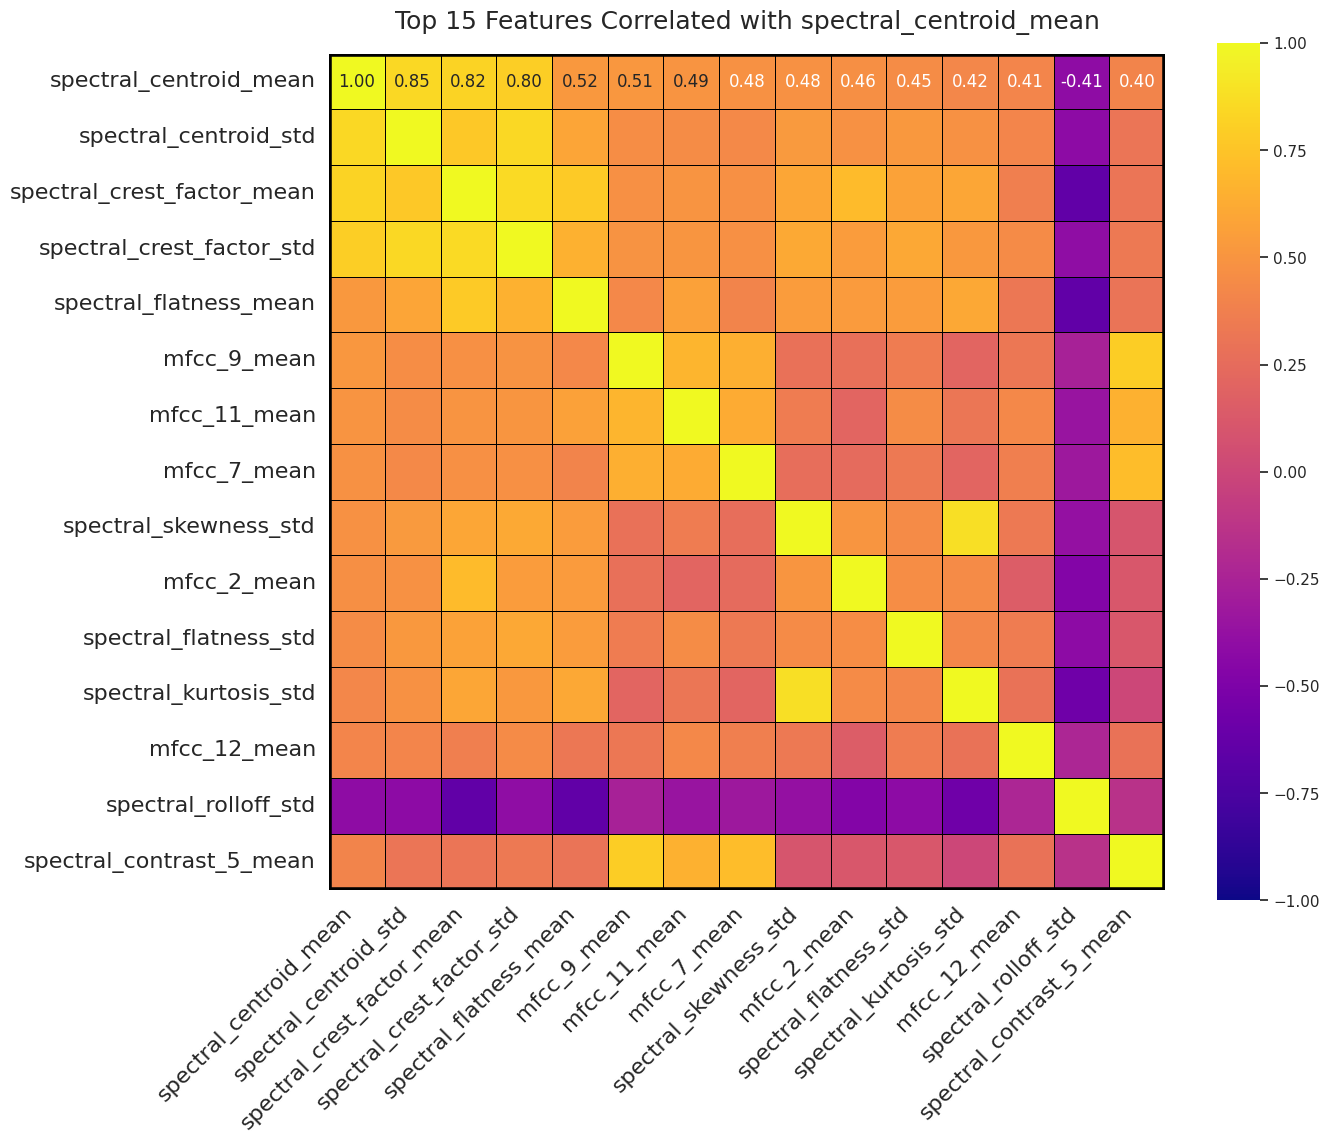

In [23]:
feature_name = 'spectral_centroid_mean'
plot_top_correlated_intra_modality_features_updated(df_dropped_090, feature_name, top_n=15)
save_fig(os.path.join('intra_modality_correlation', f"correlation_with_{feature_name}_(after dropping)"))

### 3. Top Correlated Features for Each Individual Output Category:

- After removing redundant features
- The labels in the column `class_name` are categorical strings. Correlation with categorical strings doesn't make sense in the context of Spearman or Pearson correlation. 
- One way to handle this is to convert each class to a binary format, where 1 indicates the presence of the class and 0 indicates the absence.

By understanding which features are most indicative of each category, you can gain insights into the nature of the data and the categories themselves.
Certain phenomena might be more easily captured by one modality over another.

Saving figure correlation_target/CM-Balling-dropped_090
Saving figure correlation_target/CM-Laser-off-dropped_090
Saving figure correlation_target/CM-Non-defective-dropped_090


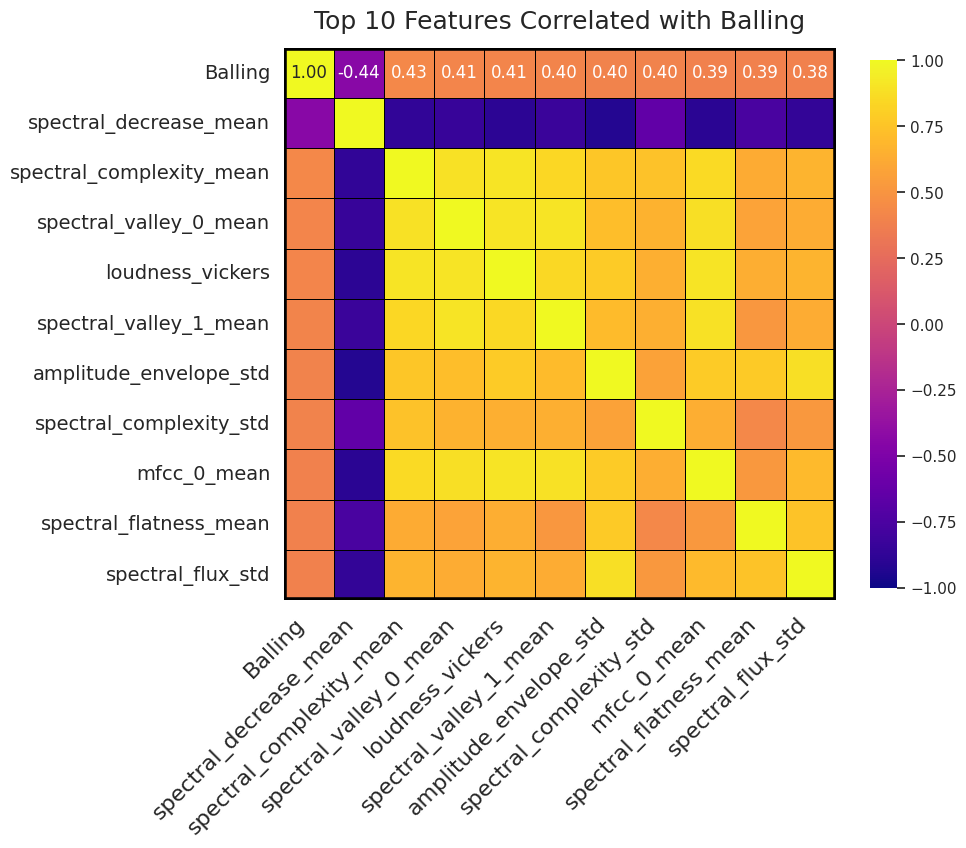

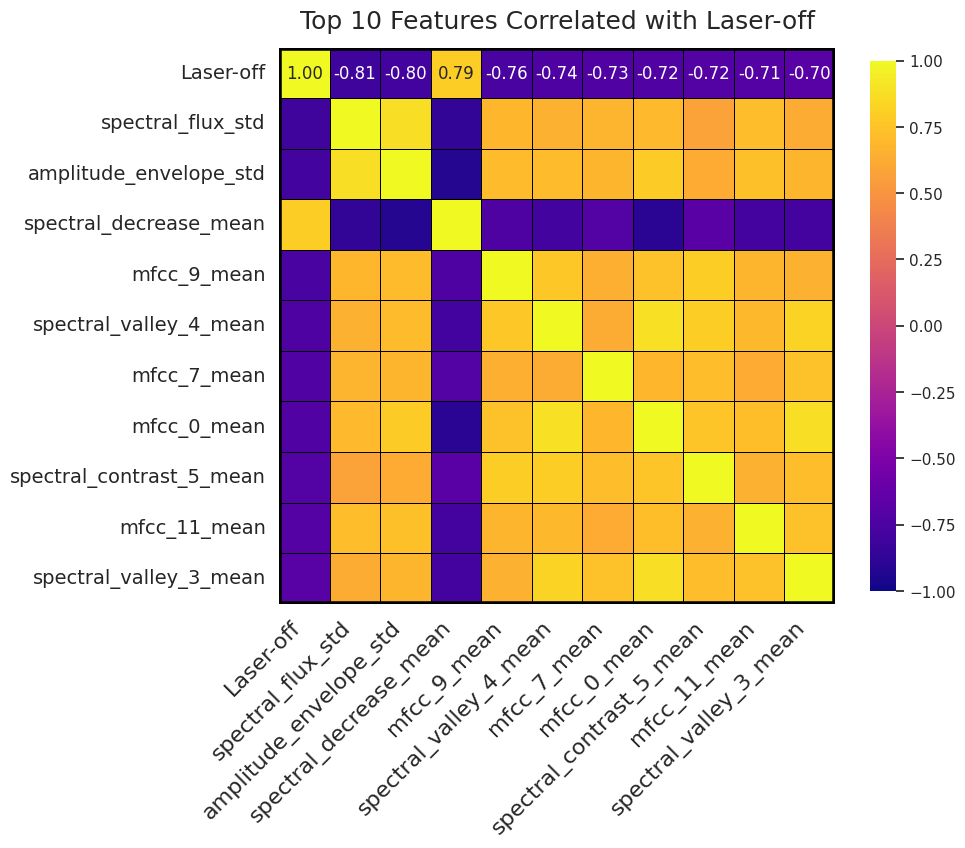

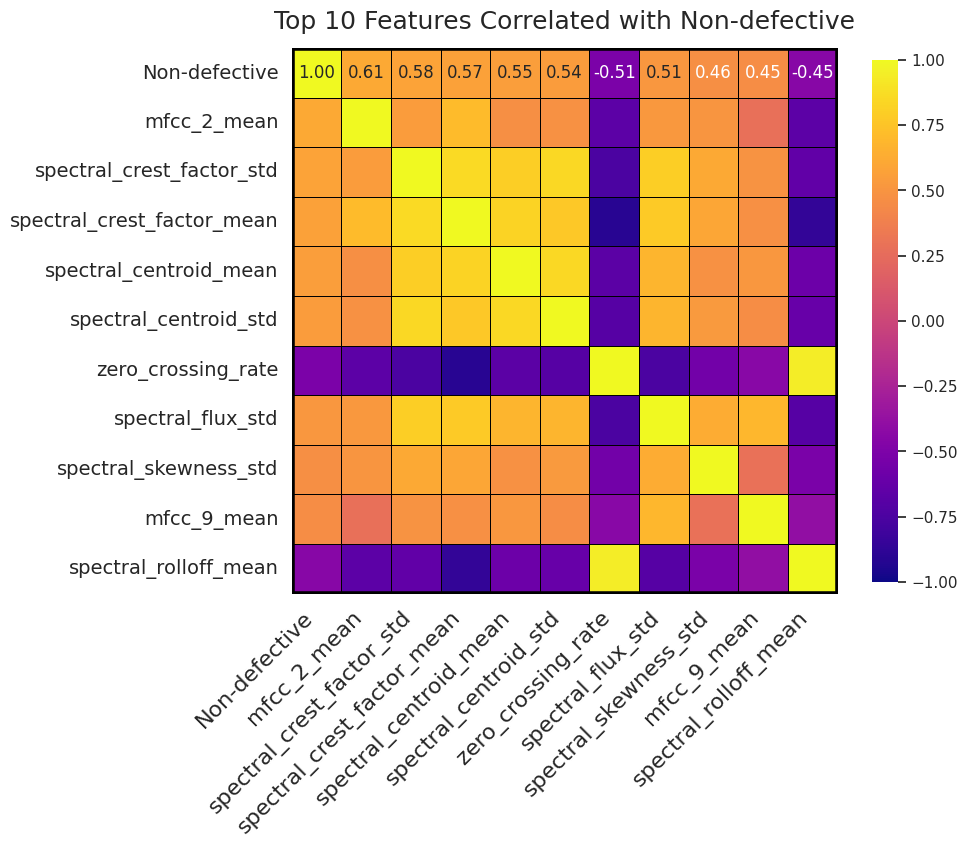

In [24]:
def plot_custom_style_top_correlated_features(dataset, target_column, method='spearman', top_n=10):
    # Convert the target_column to binary format
    dataset_binary = dataset.copy()
    dataset_binary[target_column] = pd.get_dummies(dataset_binary['label_1'])[target_column]

    # Drop non-feature columns
    non_feature_columns = ['audio_name', 'image_name', 'experiment_number',
                       'label_1', 'label_2', 'label_3']
    dataset_dropped = dataset_binary.drop(columns=non_feature_columns)
    
    # Compute correlations with the target column using Spearman/Pearson correlation
    correlations_with_target = dataset_dropped.corr(method=method)[target_column].drop(target_column)
    
    # Get top N absolute correlations (including the target)
    top_correlations = correlations_with_target.abs().nlargest(top_n - 1).index
    top_correlations = top_correlations.insert(0, target_column)
    top_correlation_values = dataset_dropped[top_correlations].corr(method=method)

    # Adjust figure size for 'Keyhole pores'
    fig_size = (10, 9) # 11,10
    # fig_size = (11, 10) if target_column == 'Keyhole pores' else (10, 8)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .8},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=14
    )
    ax.axhline(y=0, color='k', linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k', linewidth=4)
    ax.axvline(x=0, color='k', linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k', linewidth=4)
    plt.title(f"Top {top_n-1} Features Correlated with {target_column}", fontsize=18, y=1.02)


quality_categories = ['Balling', 'Laser-off', 'Non-defective']

# Loop over each material category to generate the plot
for quality in quality_categories:
    plot_custom_style_top_correlated_features(df_dropped_097, quality, method='spearman', top_n=11)
    save_fig(os.path.join('correlation_target', f"CM-{quality}-dropped_090"))

### 4. Correlation with overall output Class

This step is about understanding the overall relationship between features and the target, regardless of the specific categories within the target. It gives a holistic view and can be particularly useful for:
1. Feature selection: If certain features are very weakly correlated with the overall target, they might not be useful predictors.
2. Understanding the general importance of features: While individual category correlations give insights about specific classes, this step gives a broader perspective.
3. Preparing for machine learning models that might treat the problem as multi-class without focusing on individual categories.

In [25]:
df_dropped_090.columns

Index(['audio_name', 'image_name', 'experiment_number', 'label_1', 'label_2',
       'label_3', 'spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_complexity_std', 'spectral_contrast_0_mean',
       'spectral_contrast_0_std', 'spectral_contrast_1_mean',
       'spectral_contrast_1_std', 'spectral_contrast_2_mean',
       'spectral_contrast_2_std', 'spectral_contrast_3_mean',
       'spectral_contrast_3_std', 'spectral_contrast_4_mean',
       'spectral_contrast_4_std', 'spectral_contrast_5_mean',
       'spectral_valley_0_std', 'spectral_valley_1_std',
       'spectral_valley_2_mean', 'spectral_valley_2_std',
       'spectral_valley_3_std', 'spectral_valley_4_std',
       'spectral_valley_5_mean', 'spectral_energy_band_ratio_std',
       'spectral_flatness_mean', 'spectral_flatness_std',
       'spectral_rolloff_std', 'spectral_strong_peak_mean',
       'spectral_strong_peak_std', 'spectral_variance_mean',
       'spectral_variance_std', 'spectral_skewness_std',
      

Saving figure correlation_target/Top 15 Features Correlated with label_1 (-97)


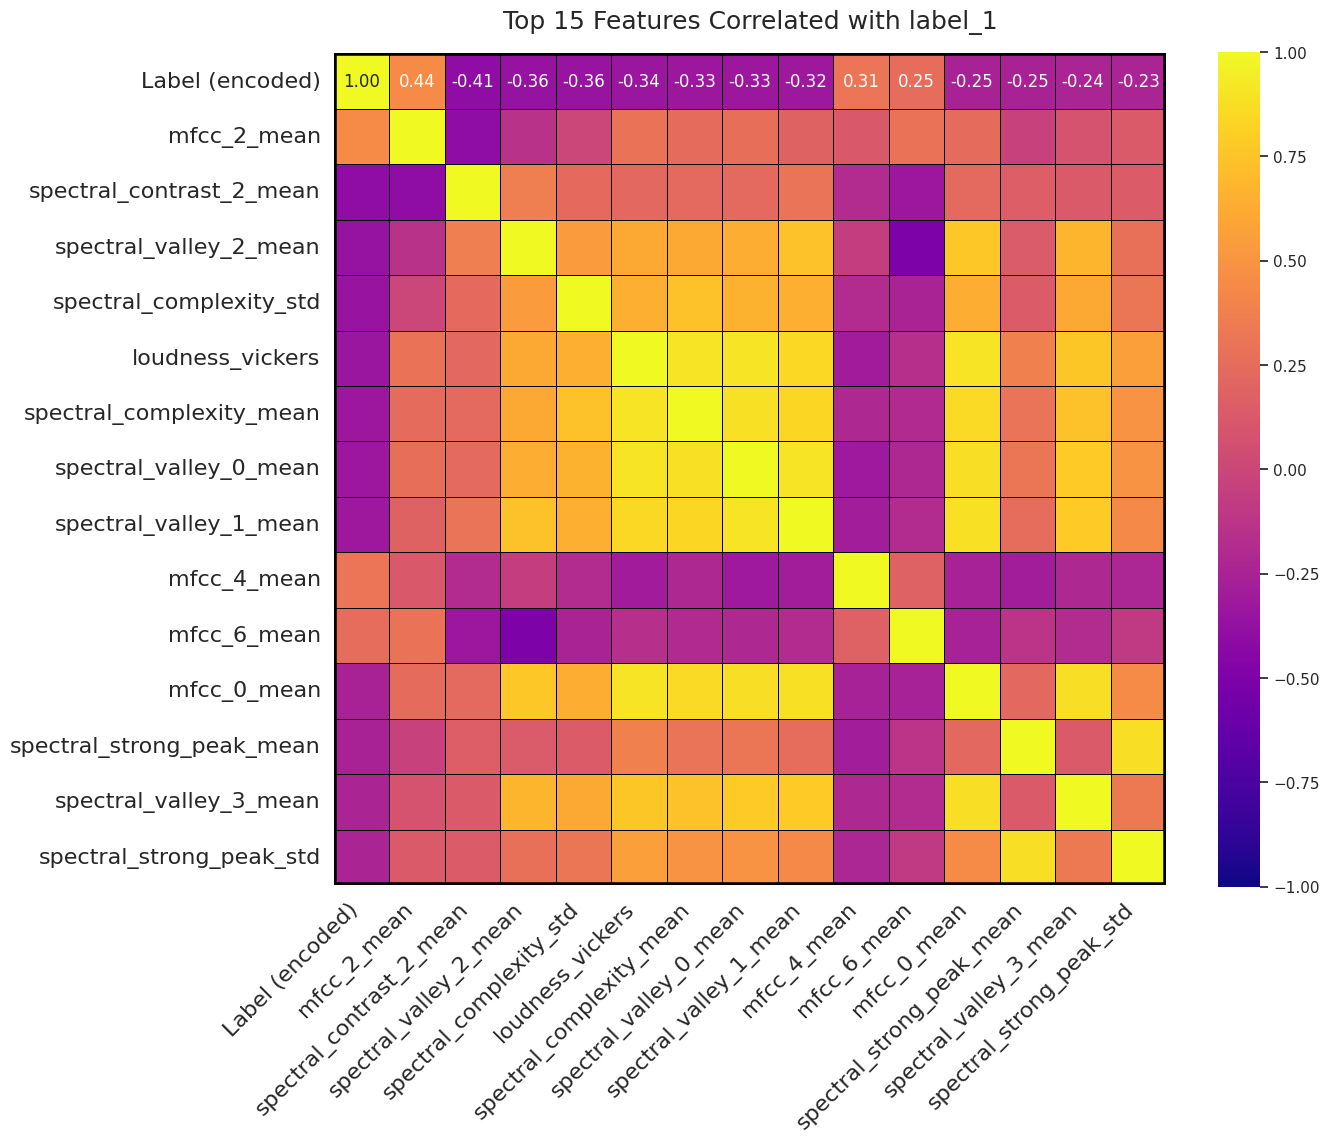

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def plot_correlation_with_output_class(dataset, target_column='class_name', method='spearman', top_n=10):
    
    # Remove non-feature columns
    non_feature_columns = ['audio_name', 'image_name', 'experiment_number',
                       'label_1', 'label_2', 'label_3']
    dataset_features = dataset.drop(columns=non_feature_columns)
    
    # Convert categorical class labels into numeric labels
    le = LabelEncoder()
    dataset_features['Label (encoded)'] = le.fit_transform(dataset[target_column])
    
    # Compute correlations with the target class
    correlations = dataset_features.corr(method=method)
    correlations_with_class = correlations['Label (encoded)']
    
    # Get top N absolute correlations (including the target class)
    top_correlations = correlations_with_class.abs().nlargest(top_n).index
    top_correlation_values = dataset_features[top_correlations].corr(method=method)
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {target_column}", fontsize=18, y=1.02)
    # save_fig(f"Top {top_n} Features Correlated with {target_column}")
    # plt.show()

# Usage
target_column = 'label_1'
top_n = 15
plot_correlation_with_output_class(df_dropped_097, target_column=target_column, method='spearman', top_n=top_n)
save_fig(os.path.join('correlation_target', f"Top {top_n} Features Correlated with {target_column} (-97)"))

### Feature importance ranking by RF

In [27]:
# Re-defining the functions for feature importance calculation and plotting for both classification and regression tasks

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_save_feature_importance(importances, feature_names, top_n, title, file_name):
    """Plot and save the feature importance graph."""
    feat_importances = pd.Series(importances, index=feature_names)
    
    # Plotting the feature importances
    fig = plt.figure(figsize=(8, 5), dpi=300)
    ax = plt.gca()
    widths = 2
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(widths)

    # Color palette suitable for scientific publications
    color = plt.cm.viridis(np.linspace(0, 1, top_n))

    feat_importances.nlargest(top_n).plot(kind='barh', color=color, edgecolor='k', linewidth=0.5)
    plt.title(title, fontsize=12, y=1.02)
    plt.xlabel('Relative Importance', fontsize=14, labelpad=10)
    # plt.ylabel('Feature Names', fontsize=14, labelpad=10)
    plt.tick_params(axis='both', labelsize=12, pad=5)

    # Save the figure
    save_fig(os.path.join(file_name))


def feature_importance_classification(df, target_column='label_1', top_n=20, save_name='RF_feature_importance'):
    """Calculate and plot feature importances for classification task."""
    # Remove NaN rows based on target column
    df = df.dropna(subset=[target_column])
    
    # Define the dataset and target variable
    y = df[target_column]

    non_feature_columns = ['audio_name', 'image_name', 'experiment_number',
                       'label_1', 'label_2', 'label_3']
    dataset_dropped = df.drop(columns=non_feature_columns)

    # Initialize the RandomForestClassifier and fit
    model = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    model.fit(dataset_dropped, y)

    # Extract feature importances
    plot_save_feature_importance(model.feature_importances_, dataset_dropped.columns, top_n,
                                 "RF Feature Importance", save_name)


# Function to calculate and plot feature importance for regression task
def feature_importance_regression(df, target_column='max_contour_area', top_n=20, save_name='RF_feature_importance'):
    y = df[target_column]
    
    # Filter out audio features that actually exist in the dataframe
    available_audio_features = [col for col in audio_features if col in df.columns]

    # Since the target is a visual feature, only consider audio features
    dataset_dropped = df[available_audio_features]

    model = RandomForestRegressor(n_estimators=50, n_jobs=-1)
    model.fit(dataset_dropped, y)
    plot_save_feature_importance(model.feature_importances_, dataset_dropped.columns, top_n, 
                                 "RF Feature Importance", save_name)



Saving figure RF_feature_importance(90)-top 20


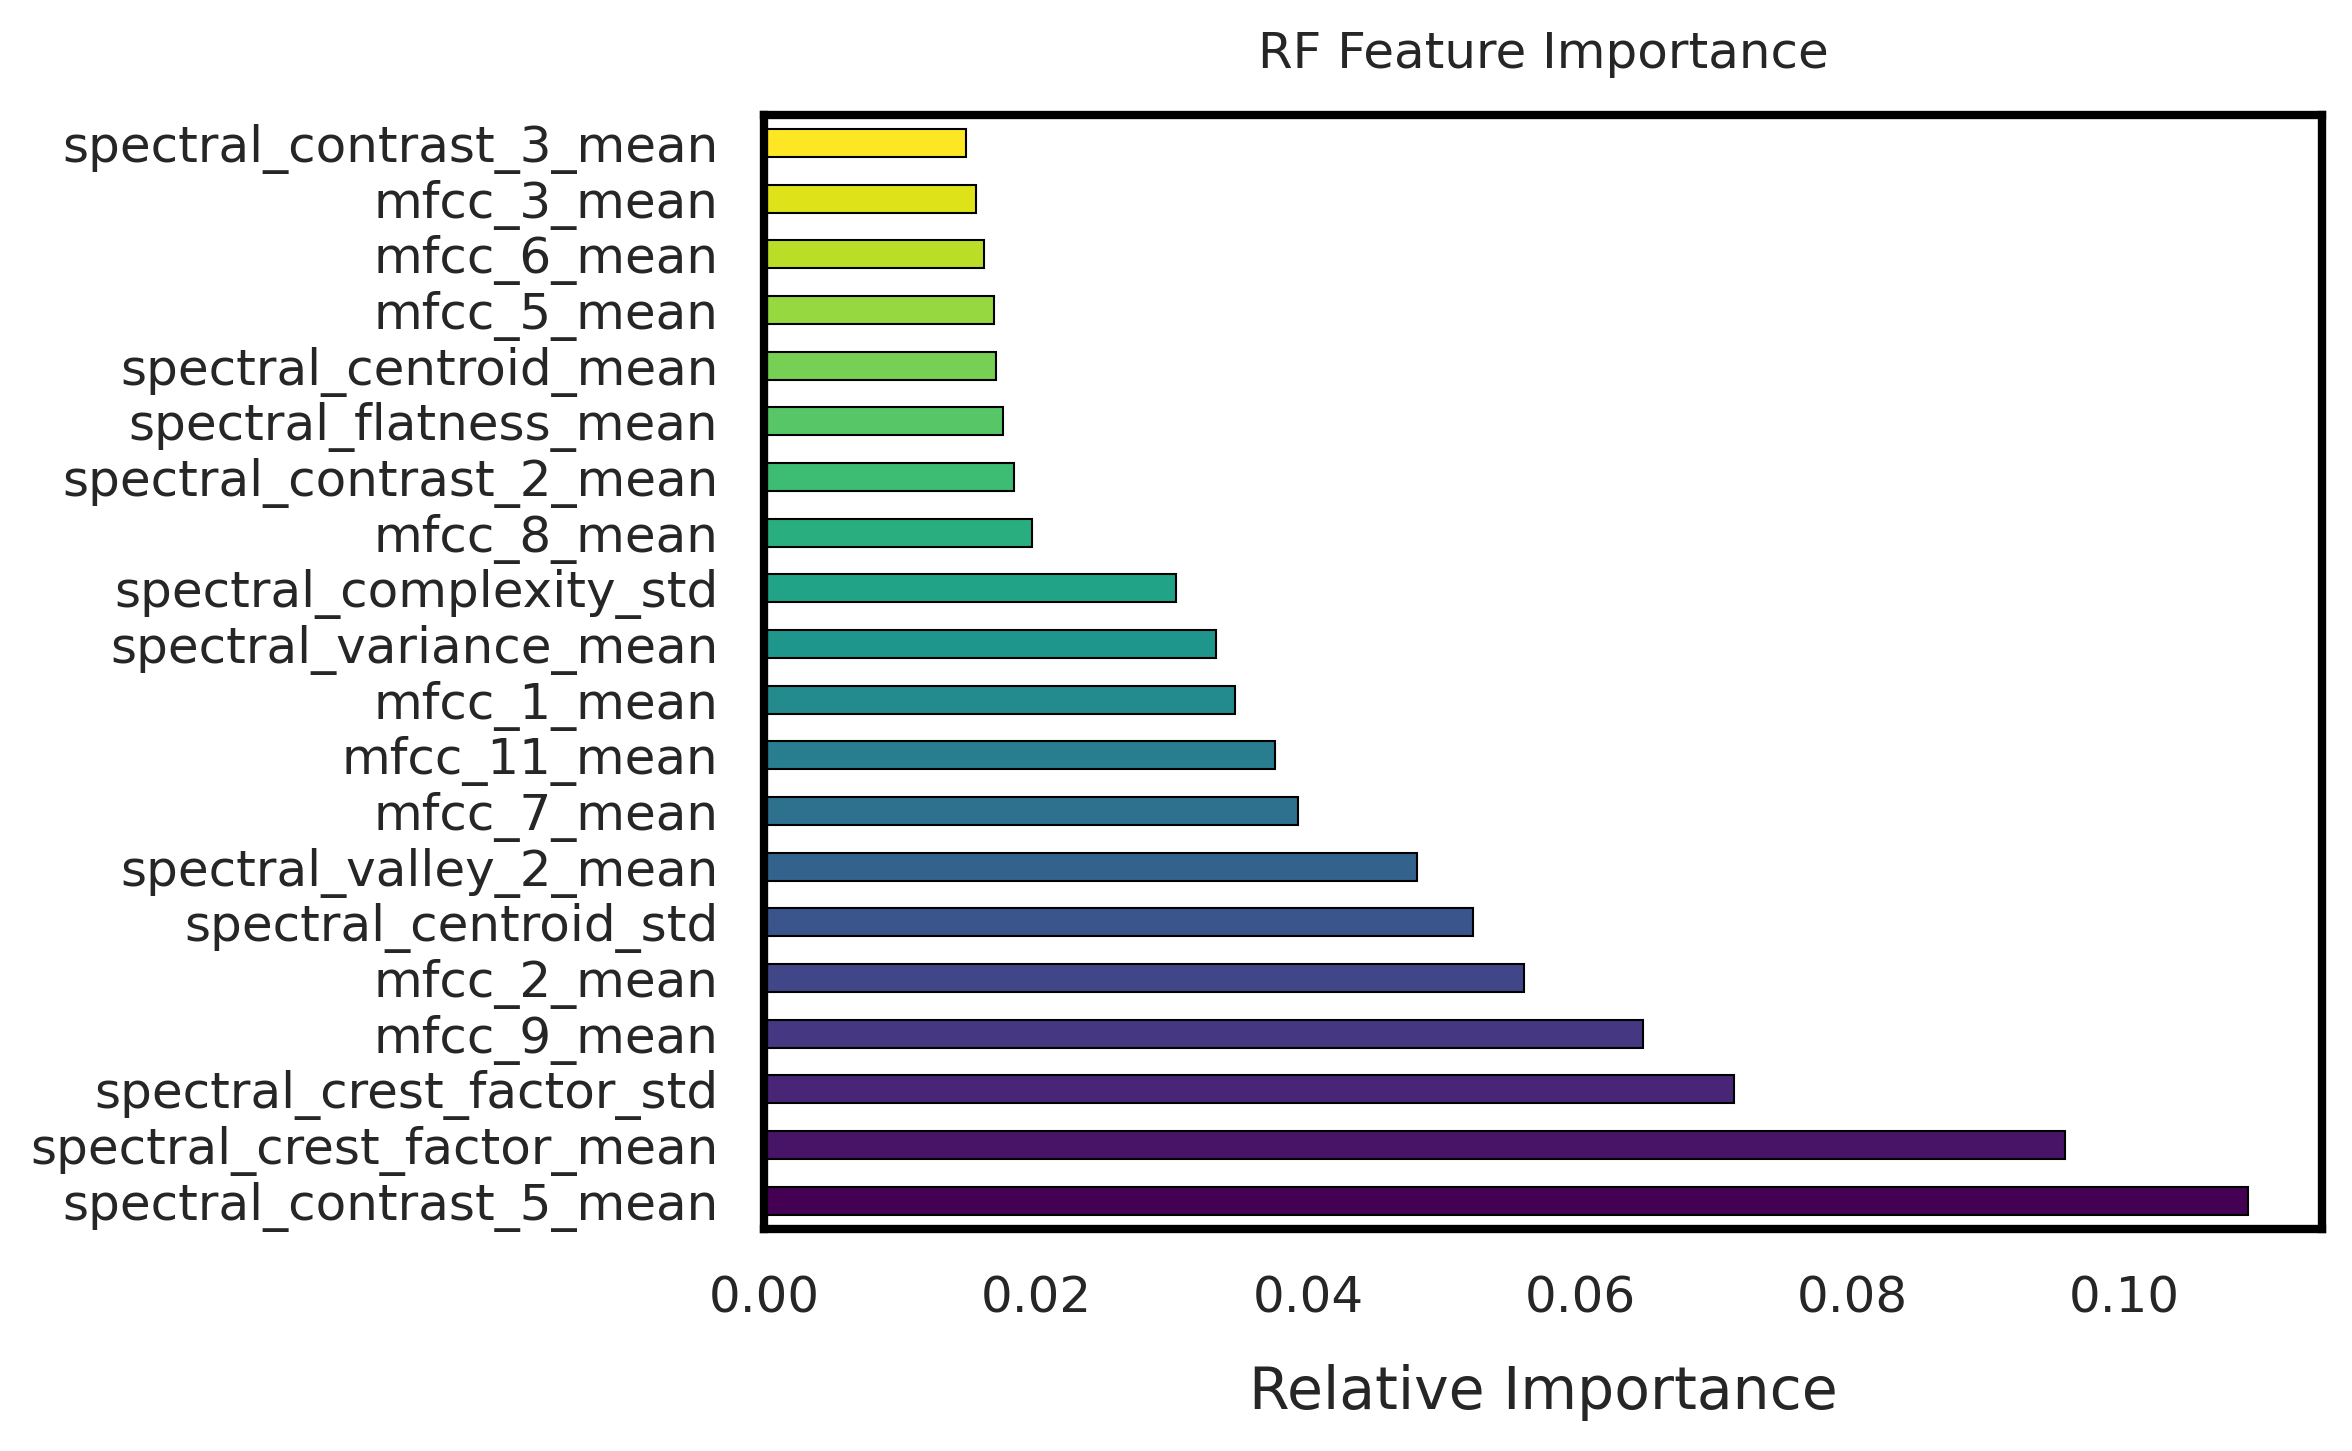

In [28]:
top_n = 20
save_name = f"RF_feature_importance(90)-top {top_n}"
feature_importance_classification(df_dropped_090, top_n=top_n, save_name = save_name)

### 5. ANOVA (Analysis of Variance) analysis

Explanation of F-value and P-value in ANOVA

- `F-value`: In the context of ANOVA (Analysis of Variance), the F-value represents the ratio of the variance between different groups to the variance within the groups. A __higher F-value__ suggests that the feature is important in distinguishing between the different classes in the target variable.

- `Null Hypothesis in ANOVA`: The null hypothesis in ANOVA is that all classes of the target variable have the same mean for the feature being tested. In other words, the feature doesn't help in distinguishing between different classes.

- `P-value`: It's a measure to support or refute this null hypothesis. The P-value tells you the probability of observing your data, or something more extreme, if the null hypothesis is true.
    - The P-value gives the probability of obtaining an F-value at least as extreme as the one computed, assuming that the null hypothesis is true (i.e., that there's no effect or difference). A __lower P-value (< 0.05 is often considered)__ indicates that you can reject the null hypothesis, making the feature important.

    - `Low P-value` (typically < 0.05): It means that it's very unlikely to observe such data if the null hypothesis is true. This gives you enough evidence to "reject the null hypothesis" and conclude that the feature is significant in distinguishing between different classes.

    - `High P-value`: It means that what you've observed is likely under the null hypothesis, so you don't have enough evidence to reject it. This would mean that the feature is not very useful in distinguishing between different classes.
    
- For  feature importance, the bar plot represents the top N features sorted by their F-values in the first graph and by their Mutual Information scores in the second graph.  The features at the top are considered to be more important in predicting the target variable.

In [29]:
# Importing required libraries
from sklearn.feature_selection import f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def anova_feature_importance(dataset, X, y, top_n=10):
    """
    Compute and plot the ANOVA F-values and P-values for feature importance.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - X (array): Feature matrix.
    - y (array): Target array.
    - top_n (int): Number of top features to display.
    
    Returns:
    - sorted_df (pd.DataFrame): Sorted DataFrame containing F-values and P-values.
    """
    # Compute ANOVA F-values and P-values
    f_values, p_values = f_classif(X, y)
    
    # Create DataFrame for ANOVA feature importance
    anova_importance_df = pd.DataFrame({
        'Feature': dataset.columns,
        'F_value': f_values,
        'p_value': p_values
    })

    # Sort the features by F_value in descending order
    sorted_df = anova_importance_df.sort_values(by='F_value', ascending=False)
    
    # Get the top N features
    top_features = sorted_df.head(top_n)
    
    # Plotting F-values
    plt.figure(figsize=(14, 8))
    plt.barh(top_features['Feature'], top_features['F_value'], color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('F-value', fontsize=18, labelpad=15)
    plt.ylabel('Feature', fontsize=18, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'Top {top_n} Features using ANOVA F-value', pad=15, fontsize=20)
    # save_fig(f'Top {top_n} Features using ANOVA F-value')
    # plt.show()
    
    # Plotting P-values
    # plt.figure(figsize=(12, 10))
    # plt.barh(top_features['Feature'], top_features['p_value'], color='orange', edgecolor='black', linewidth=0.5)
    # plt.xlabel('P-value', fontsize=18, labelpad=15)
    # plt.ylabel('Feature', fontsize=18, labelpad=15)
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)
    # plt.title(f'Top {top_n} Features using ANOVA P-value', pad=15, fontsize=20)
    # plt.show()
    
    return sorted_df

Saving figure Top 20 Features using ANOVA F-value (dropped_090)


,Feature,F_value,p_value
32,spectral_crest_factor_std,2516.877185,0.000000e+00
50,mfcc_9_mean,2250.216222,0.000000e+00
31,spectral_crest_factor_mean,1816.667576,0.000000e+00
54,mfcc_11_mean,1801.073543,0.000000e+00
46,mfcc_7_mean,1700.720739,0.000000e+00
1,spectral_centroid_std,1561.458826,0.000000e+00
36,mfcc_2_mean,1499.254165,0.000000e+00
0,spectral_centroid_mean,1451.121289,0.000000e+00
13,spectral_contrast_5_mean,1350.029198,0.000000e+00
2,spectral_complexity_std,1230.150011,0.000000e+00


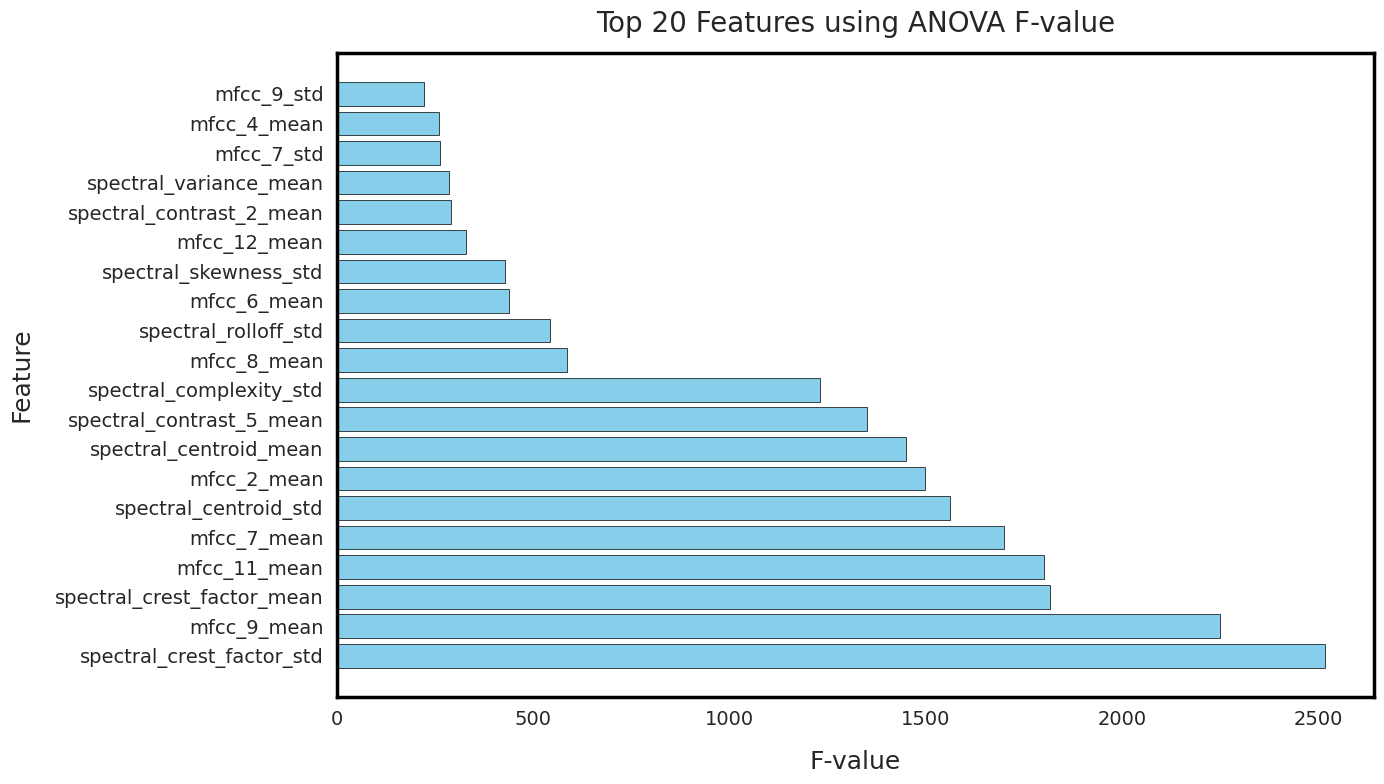

In [30]:
# Prepare data
non_feature_columns = ['audio_name', 'image_name', 'experiment_number',
                       'label_1', 'label_2', 'label_3']
target_column = 'label_1'
df = df_dropped_090.dropna(subset=[target_column])
dataset = df.drop(columns=non_feature_columns)
X = dataset.to_numpy()
y = df['label_1'].to_numpy()


# Run the function 
sorted_df = anova_feature_importance(dataset, X, y, top_n=20)
save_fig(f'Top {top_n} Features using ANOVA F-value (dropped_090)')
sorted_df

### Feature selection based on ANOVA
- A `higher F-value` generally suggests that the feature is __more important or discriminative__ for classification. It indicates that the means of the different classes are more separated, which usually implies the feature is good for classification.

- A `lower p-value` means that the feature is __statistically significant__ in explaining the dependent variable. A  `p-value less than a threshold (commonly 0.05)` is typically considered evidence that the feature is important.

- However, a higher F-value does not necessarily mean a lower p-value, although they are often inversely related in many cases. The p-value is calculated based on the  F-value and the degrees of freedom in the model. It's possible for a feature to have a high  F-value but still not be statistically significant if, for example, the degrees of freedom are low.

In [31]:
def filter_anova_features(sorted_df, p_value_threshold=0.05, f_value_threshold=None):
    """
    Filter features based on ANOVA F-value and p-value.
    
    Args:
    - sorted_df (pd.DataFrame): The input DataFrame containing 'Feature', 'F_value', and 'p_value' columns.
    - p_value_threshold (float): The p-value threshold for feature elimination. Default is 0.05.
    - f_value_threshold (float): The F-value threshold for feature elimination. If None, it won't be used.
    
    Returns:
    - significant_features (list): List of significant features based on p_value and F_value.
    - insignificant_features (list): List of insignificant features based on p_value.
    """
    # Filter features based on p-value
    significant_df = sorted_df[sorted_df['p_value'] <= p_value_threshold]
    
    # Filter features based on F-value if specified
    if f_value_threshold is not None:
        significant_df = significant_df[significant_df['F_value'] >= f_value_threshold]
    
    # Get the list of significant and insignificant features
    significant_features = significant_df['Feature'].tolist()
    insignificant_features = sorted_df.loc[~sorted_df['Feature'].isin(significant_features), 'Feature'].tolist()
    
    return significant_features, insignificant_features


significant_features, insignificant_features = filter_anova_features(sorted_df, p_value_threshold=0.0001)
print("Significant features:", significant_features)
print("Insignificant features:", insignificant_features)

Significant features: ['spectral_crest_factor_std', 'mfcc_9_mean', 'spectral_crest_factor_mean', 'mfcc_11_mean', 'mfcc_7_mean', 'spectral_centroid_std', 'mfcc_2_mean', 'spectral_centroid_mean', 'spectral_contrast_5_mean', 'spectral_complexity_std', 'mfcc_8_mean', 'spectral_rolloff_std', 'mfcc_6_mean', 'spectral_skewness_std', 'mfcc_12_mean', 'spectral_contrast_2_mean', 'spectral_variance_mean', 'mfcc_7_std', 'mfcc_4_mean', 'mfcc_9_std', 'spectral_contrast_4_mean', 'mfcc_10_mean', 'mfcc_1_mean', 'mfcc_3_mean', 'mfcc_3_std', 'spectral_variance_std', 'spectral_strong_peak_mean', 'mfcc_5_mean', 'mfcc_4_std', 'spectral_strong_peak_std', 'spectral_flatness_mean', 'mfcc_5_std', 'spectral_contrast_2_std', 'mfcc_8_std', 'spectral_contrast_3_mean', 'mfcc_2_std', 'spectral_kurtosis_std', 'mfcc_6_std', 'spectral_contrast_0_mean', 'spectral_flatness_std', 'spectral_energy_band_ratio_std', 'spectral_contrast_1_mean', 'mfcc_1_std', 'mfcc_11_std', 'mfcc_0_std', 'spectral_contrast_1_std', 'mfcc_10_std'

### 6. Mutual Informaion analysis

- Principle and Idea:

`Mutual Information (MI)` is a measure of the amount of information that one random variable contains about another. It is used in feature selection to evaluate how much information a feature (independent variable) provides about the target (dependent variable).

- How it works:

    - `Zero MI`: If the MI between a feature and the target is zero, then the feature is statistically independent of the target, i.e., it gives no information about the target.
    - `High MI`: A higher MI value suggests that knowing the value of the feature would give more information about the outcome of the target variable.

- How it is used for Feature Importance:
    - Ranking Features: After calculating MI for all features, you can rank them based on their MI values. Higher MI values suggest more important features.

- Feature Selection: You can set a threshold on the MI value to select features. Features with MI values above this threshold are usually selected.

- How it is different from ANOVA or other methods:
    - MI is a non-parametric method, meaning it doesn't assume any specific distribution for the data.
    - It can capture any kind of relationship (linear or nonlinear) between the feature and the target.

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

def mutual_info_feature_importance(dataset, X, y, top_n=10):
    """
    Compute and plot the Mutual Information for feature importance.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - X (array): Feature matrix.
    - y (array): Target array.
    - top_n (int): Number of top features to display.
    
    Returns:
    - sorted_df (pd.DataFrame): DataFrame containing features and their Mutual Information values, sorted.
    """
    
    # Compute Mutual Information
    mi_values = mutual_info_classif(X, y)
    
    # Create a DataFrame to hold feature names and their corresponding Mutual Information values
    feature_importances = pd.DataFrame({'feature': dataset.columns, 'mi_value': mi_values})
    
    # Sort the features by their Mutual Information values in descending order
    sorted_df = feature_importances.sort_values('mi_value', ascending=False)
    
    # Get the top N features
    top_features = sorted_df.head(top_n)
    
    # Plotting
    plt.figure(figsize=(14, 8))
    bars = plt.barh(top_features['feature'], top_features['mi_value'], color='orange', edgecolor='black', linewidth=0.5)
    plt.xlabel('Mutual Information', fontsize=18, labelpad=15)
    plt.ylabel('Feature', fontsize=18, labelpad=15)
    plt.title(f'Top {top_n} Features using Mutual Information', pad=15, fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    return sorted_df

Saving figure Top feature Mutual Info (dropped_090)


,feature,mi_value
13,spectral_contrast_5_mean,0.483102
31,spectral_crest_factor_mean,0.431036
32,spectral_crest_factor_std,0.431034
50,mfcc_9_mean,0.415080
54,mfcc_11_mean,0.379555
16,spectral_valley_2_mean,0.370570
46,mfcc_7_mean,0.366245
0,spectral_centroid_mean,0.361848
36,mfcc_2_mean,0.322561
1,spectral_centroid_std,0.321977


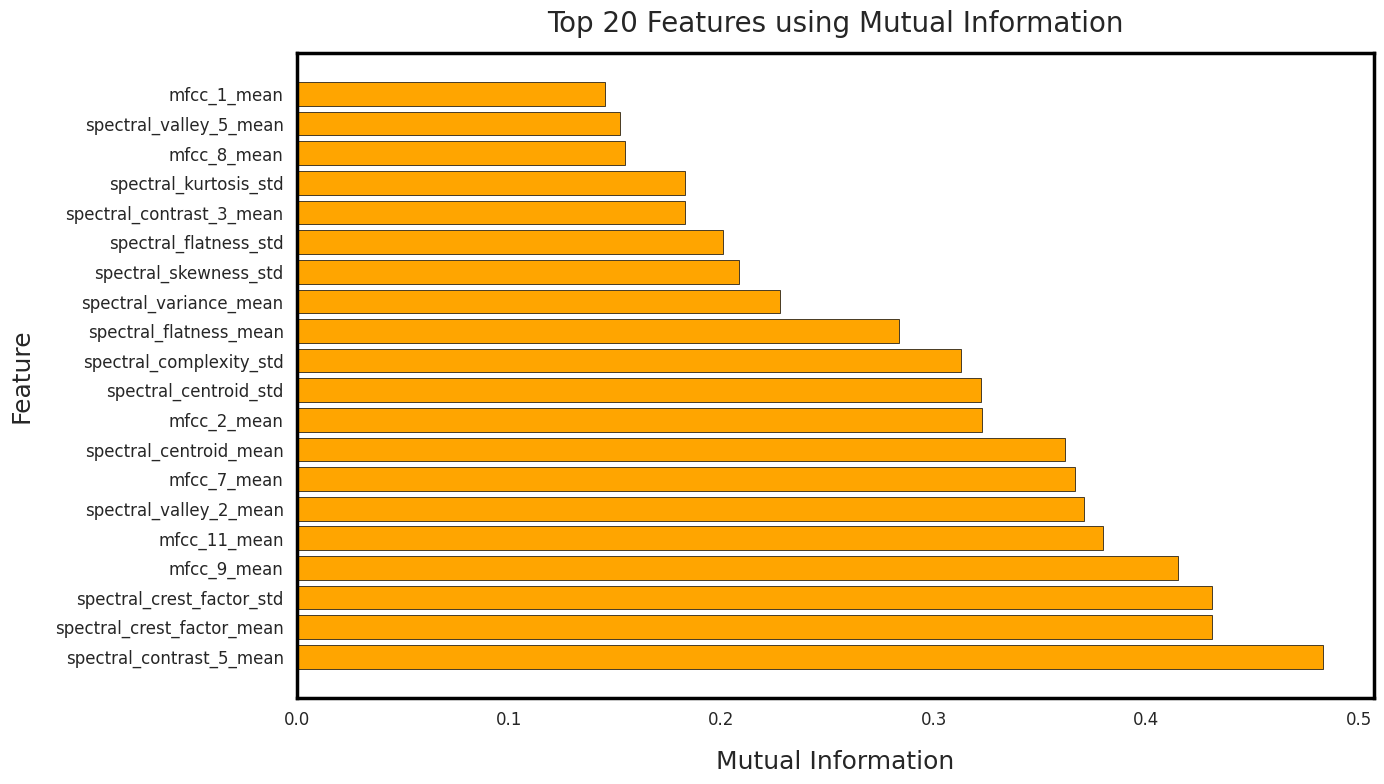

In [33]:
df = df_dropped_090.dropna(subset=[target_column])
dataset = df.drop(columns=non_feature_columns)
X = dataset.to_numpy()
y = df['label_1'].to_numpy()

sorted_df = mutual_info_feature_importance(dataset, X, y, top_n=20)
save_fig("Top feature Mutual Info (dropped_090)")
sorted_df

In [34]:
# Function to filter features based on Mutual Information (MI) threshold
def filter_mi_features(mi_importance_df, mi_threshold):
    """
    Filter features based on a given Mutual Information (MI) threshold.
    
    Args:
    - mi_importance_df (pd.DataFrame): DataFrame containing features and their MI values.
    - mi_threshold (float): The MI threshold for feature selection.
    
    Returns:
    - filtered_features (list): List of features that have MI values greater than or equal to the threshold.
    - removed_features (list): List of features that have MI values smaller than the threshold.
    """
    # Filter the features
    significant_features = mi_importance_df[mi_importance_df['mi_value'] >= mi_threshold]['feature'].tolist()
    insignificant_features = mi_importance_df[mi_importance_df['mi_value'] < mi_threshold]['feature'].tolist()
    
    return significant_features, insignificant_features

In [35]:
significant_features_005, insignificant_features_005 = filter_mi_features(sorted_df, mi_threshold=0.05)
significant_features_01, insignificant_features_01 = filter_mi_features(sorted_df, mi_threshold=0.1)
print("Significant features: \n", significant_features_01, "\n")

print("Insignificant features: \n", insignificant_features_01)

Significant features: 
 ['spectral_contrast_5_mean', 'spectral_crest_factor_mean', 'spectral_crest_factor_std', 'mfcc_9_mean', 'mfcc_11_mean', 'spectral_valley_2_mean', 'mfcc_7_mean', 'spectral_centroid_mean', 'mfcc_2_mean', 'spectral_centroid_std', 'spectral_complexity_std', 'spectral_flatness_mean', 'spectral_variance_mean', 'spectral_skewness_std', 'spectral_flatness_std', 'spectral_contrast_3_mean', 'spectral_kurtosis_std', 'mfcc_8_mean', 'spectral_valley_5_mean', 'mfcc_1_mean', 'mfcc_6_mean', 'spectral_rolloff_std', 'spectral_contrast_2_mean', 'mfcc_5_mean', 'mfcc_4_mean', 'mfcc_3_mean', 'spectral_contrast_4_mean', 'mfcc_12_mean'] 

Insignificant features: 
 ['spectral_strong_peak_std', 'spectral_energy_band_ratio_std', 'mfcc_7_std', 'spectral_strong_peak_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_0_std', 'spectral_variance_std', 'mfcc_3_std', 'spectral_valley_3_std', 'mfcc_1_std', 'mfcc_5_std', 'spectral_valley_2_std', 'spectral_contrast_2_std', 'spectral_valley_0_std', 'mfcc_8_s

In [36]:
df_dropped_090_mi_filtered_005 = df_dropped_090.drop(columns=insignificant_features_005)
df_dropped_090_mi_filtered_01 = df_dropped_090.drop(columns=insignificant_features_01)

### Save processed features into h5 file

In [37]:
df_dropped_097.to_hdf(os.path.join(Dataset_path, 'dataset_dropped_97.h5'), key='df', mode='w', format='table')

In [38]:
df_dropped_090.to_hdf(os.path.join(Dataset_path, 'dataset_dropped_90.h5'), key='df', mode='w', format='table')

In [39]:
df_dropped_090_mi_filtered_01.to_hdf(os.path.join(Dataset_path, 'dataset_dropped_90_mi_filtered_01.h5'), key='df', mode='w', format='table')

In [40]:
df_dropped_090_mi_filtered_005.to_hdf(os.path.join(Dataset_path, 'dataset_dropped_90_mi_filtered_005.h5'), key='df', mode='w', format='table')

In [41]:
df_dropped_090_mi_filtered_005.columns

Index(['audio_name', 'image_name', 'experiment_number', 'label_1', 'label_2',
       'label_3', 'spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_complexity_std', 'spectral_contrast_2_mean',
       'spectral_contrast_3_mean', 'spectral_contrast_4_mean',
       'spectral_contrast_5_mean', 'spectral_valley_2_mean',
       'spectral_valley_3_std', 'spectral_valley_5_mean',
       'spectral_energy_band_ratio_std', 'spectral_flatness_mean',
       'spectral_flatness_std', 'spectral_rolloff_std',
       'spectral_strong_peak_mean', 'spectral_strong_peak_std',
       'spectral_variance_mean', 'spectral_variance_std',
       'spectral_skewness_std', 'spectral_kurtosis_std',
       'spectral_crest_factor_mean', 'spectral_crest_factor_std', 'mfcc_0_std',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_3_std',
       'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean',
       'mfcc_7_std', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_9_std',
       'mfcc_10_mean', 'mfcc_

In [42]:
df_dropped_097.columns

Index(['audio_name', 'image_name', 'experiment_number', 'label_1', 'label_2',
       'label_3', 'amplitude_envelope_std', 'zero_crossing_rate',
       'loudness_vickers', 'spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_complexity_mean', 'spectral_complexity_std',
       'spectral_contrast_0_mean', 'spectral_contrast_0_std',
       'spectral_contrast_1_mean', 'spectral_contrast_1_std',
       'spectral_contrast_2_mean', 'spectral_contrast_2_std',
       'spectral_contrast_3_mean', 'spectral_contrast_3_std',
       'spectral_contrast_4_mean', 'spectral_contrast_4_std',
       'spectral_contrast_5_mean', 'spectral_contrast_5_std',
       'spectral_valley_0_mean', 'spectral_valley_0_std',
       'spectral_valley_1_mean', 'spectral_valley_1_std',
       'spectral_valley_2_mean', 'spectral_valley_2_std',
       'spectral_valley_3_mean', 'spectral_valley_3_std',
       'spectral_valley_4_mean', 'spectral_valley_4_std',
       'spectral_valley_5_mean', 'spectral_valley_5_st